In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from time import strptime

import matplotlib.pyplot as plt 
import seaborn as sns 

import operator

from scipy.stats import spearmanr

from sklearn.feature_extraction.text import CountVectorizer
import re

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", UserWarning)

import plotly.express as px 

# pip install --upgrade pip, pip install --upgrade Pillow
from wordcloud import WordCloud

# Convert object columns to numeric arrays
from sklearn.preprocessing import LabelEncoder

from pyod.models.iforest import IForest

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from itertools import product

import pingouin as pg 

from scipy.stats import shapiro
from joblib import Parallel, delayed
import joblib

from pycaret.regression import *

import bz2file as bz2
import pickle

In [48]:
# read the dataset with 
# parsing the dates
# removing whitespaces
df = pd.read_csv('games.csv', skipinitialspace=True) 
df.head()

AppID                   Name  Release date Estimated owners  Peak CCU  \
0    20200       Galactic Bowling  Oct 21, 2008        0 - 20000         0   
1   655370           Train Bandit  Oct 12, 2017        0 - 20000         0   
2  1732930           Jolt Project  Nov 17, 2021        0 - 20000         0   
3  1355720               Henosis™  Jul 23, 2020        0 - 20000         0   
4  1139950  Two Weeks in Painland   Feb 3, 2020        0 - 20000         0   

   Required age  Price  DLC count  \
0             0  19.99          0   
1             0   0.99          0   
2             0   4.99          0   
3             0   5.99          0   
4             0   0.00          0   

                                      About the game  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotics ...   
3  HENOSIS™ is a mysterious 2D Platform Puzzler w...   
4  ABOUT THE GAME Play as a hacker who has arrang...   

                                 Supported languages Full audio languages  \
0                                        ['English']                   []   
1  ['English', 'French', 'Italian', 'German', 'Sp...                   []   
2                 ['English', 'Portuguese - Brazil']                   []   
3  ['English', 'French', 'Italian', 'German', 'Sp...                   []   
4                     ['English', 'Spanish - Spain']                   []   

  Reviews                                       Header image  \
0     NaN  https://cdn.akamai.steamstatic.com/steam/apps/...   
1     NaN  https://cdn.akamai.steamstatic.com/steam/apps/...   
2     NaN  https://cdn.akamai.steamstatic.com/steam/apps/...   
3     NaN  https://cdn.akamai.steamstatic.com/steam/apps/...   
4     NaN  https://cdn.akamai.steamstatic.com/steam/apps/...   

                               Website  \
0       http://www.galacticbowling.net   
1               http://trainbandit.com   
2                                  NaN   
3             https://henosisgame.com/   
4  https://www.unusual-games.com/home/   

                              Support url                    Support email  \
0                                     NaN                              NaN   
1                                     NaN          support@rustymoyher.com   
2                                     NaN        ramoncampiaof31@gmail.com   
3                https://henosisgame.com/             info@henosisgame.com   
4  https://www.unusual-games.com/contact/  welistentoyou@unusual-games.com   

   Windows    Mac  Linux  Metacritic score Metacritic url  User score  \
0     True  False  False                 0            NaN           0   
1     True   True  False                 0            NaN           0   
2     True  False  False                 0            NaN           0   
3     True   True   True                 0            NaN           0   
4     True   True  False                 0            NaN           0   

   Positive  Negative  Score rank  Achievements  Recommendations  \
0         6        11         NaN            30                0   
1        53         5         NaN            12                0   
2         0         0         NaN             0                0   
3         3         0         NaN             0                0   
4        50         8         NaN            17                0   

                                               Notes  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  This Game may contain content not appropriate ...   

   Average playtime forever  Average playtime two weeks  \
0                         0                           0   
1                         0                           0   
2                         0                 

In [49]:
# let's find the size of the dataframe 
len(df)

76987

In [50]:
# describe the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76987 entries, 0 to 76986
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       76987 non-null  int64  
 1   Name                        76985 non-null  object 
 2   Release date                76987 non-null  object 
 3   Estimated owners            76987 non-null  object 
 4   Peak CCU                    76987 non-null  int64  
 5   Required age                76987 non-null  int64  
 6   Price                       76987 non-null  float64
 7   DLC count                   76987 non-null  int64  
 8   About the game              74070 non-null  object 
 9   Supported languages         76987 non-null  object 
 10  Full audio languages        76987 non-null  object 
 11  Reviews                     9362 non-null   object 
 12  Header image                76987 non-null  object 
 13  Website                     366

In [51]:
# split the columns to numeric and object
numeric_columns = df.select_dtypes(include='number')
print("Numeric columns: ", numeric_columns.columns, "\n")

object_columns = df.select_dtypes(include='object')
print("Object columns: ", object_columns.columns, "\n")

date_columns = df.select_dtypes(include='datetime')
print("Date columns: ", date_columns.columns)

Numeric columns:  Index(['AppID', 'Peak CCU', 'Required age', 'Price', 'DLC count',
       'Metacritic score', 'User score', 'Positive', 'Negative', 'Score rank',
       'Achievements', 'Recommendations', 'Average playtime forever',
       'Average playtime two weeks', 'Median playtime forever',
       'Median playtime two weeks'],
      dtype='object') 

Object columns:  Index(['Name', 'Release date', 'Estimated owners', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email',
       'Metacritic url', 'Notes', 'Developers', 'Publishers', 'Categories',
       'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object') 

Date columns:  Index([], dtype='object')


Estimated ownersColumn | Definition
--- | -----------
AppID                      | AppID, unique identifier for each app (string).
Peak CCU                   | Number of concurrent users, yesterday (int).
Required age               | Age required to play, 0 if it is for all. 
Price                      | Price in USD, 0.0 if its free (float).
DLC count                  | Number of DLCs (Downloadable content), 0 if you have none (int). 
Metacritic score           | Metacritic score, 0 if it has none (int).
User score                 | Users score, 0 if it has none (int).
Positive                   | Positive votes (int).
Negative                   | Negative votes (int).
Score rank                 | Score rank of the game based on user reviews (string).  
Achievements               | Number of achievements, 0 if it has none (int).
Recommendations            | User recommendations, 0 if it has none (int).
Average playtime forever   | Average playtime since March 2009, in minutes. 
Average playtime two weeks | Average playtime in the last two weeks, in minutes (int).
Median playtime forever    | Median playtime since March 2009, in minutes (int).
Median playtime two weeks  | Median playtime in the last two weeks, in minutes (int).
Name                       | Game name (string).
Release date               | Release date (string).
Estimated owners           | Estimated owners (string, e.g.: "0 - 20000").
About the game             | Description (string).
Supported languages        | Comma-separated enumeration of supporting languages.
Full audio languages       | Comma-separated enumeration of languages with audio support.
Reviews                    | Game Reviews (string).
Header image               | Header image URL in the store (string).
Website                    | Game website (string).
Support url                | Game support URL (string).
Support email              | Game support email (string).
Windows                    | Supports Windows (Boolean).
Mac                        | Supports Mac (Boolean).
Linux                      | Supports Linux (Boolean).
Metacritic url             | Metacritic review URL (string).
Notes                      | Extra information about the game content (string).
Developers                 | Game developers (string).     
Publishers                 | Game publishers (string).     
Categories                 | Game categories (string).
Genres                     | Game genres (string).
Tags                       | Tags - words that describe the nature of the game (string).
Screenshots                | Game screenshots (string).
Movies                     | Game movies -links (string). 

In [52]:
# Data Engineering plan 
# 1. Correlation (general matrix and with targeted groups)
# 2. drop unrelated columns 
# 3. Duplicates (ok)
# 4. Missing values 
# 5. Customized

In [53]:
# Create a copy of the DataFrame to preserve the original data
df_copy = df.copy()

In [54]:
# Convert object columns to numeric using label encoding
for col in object_columns.columns:
    df[col] = df[col].astype('category').cat.codes

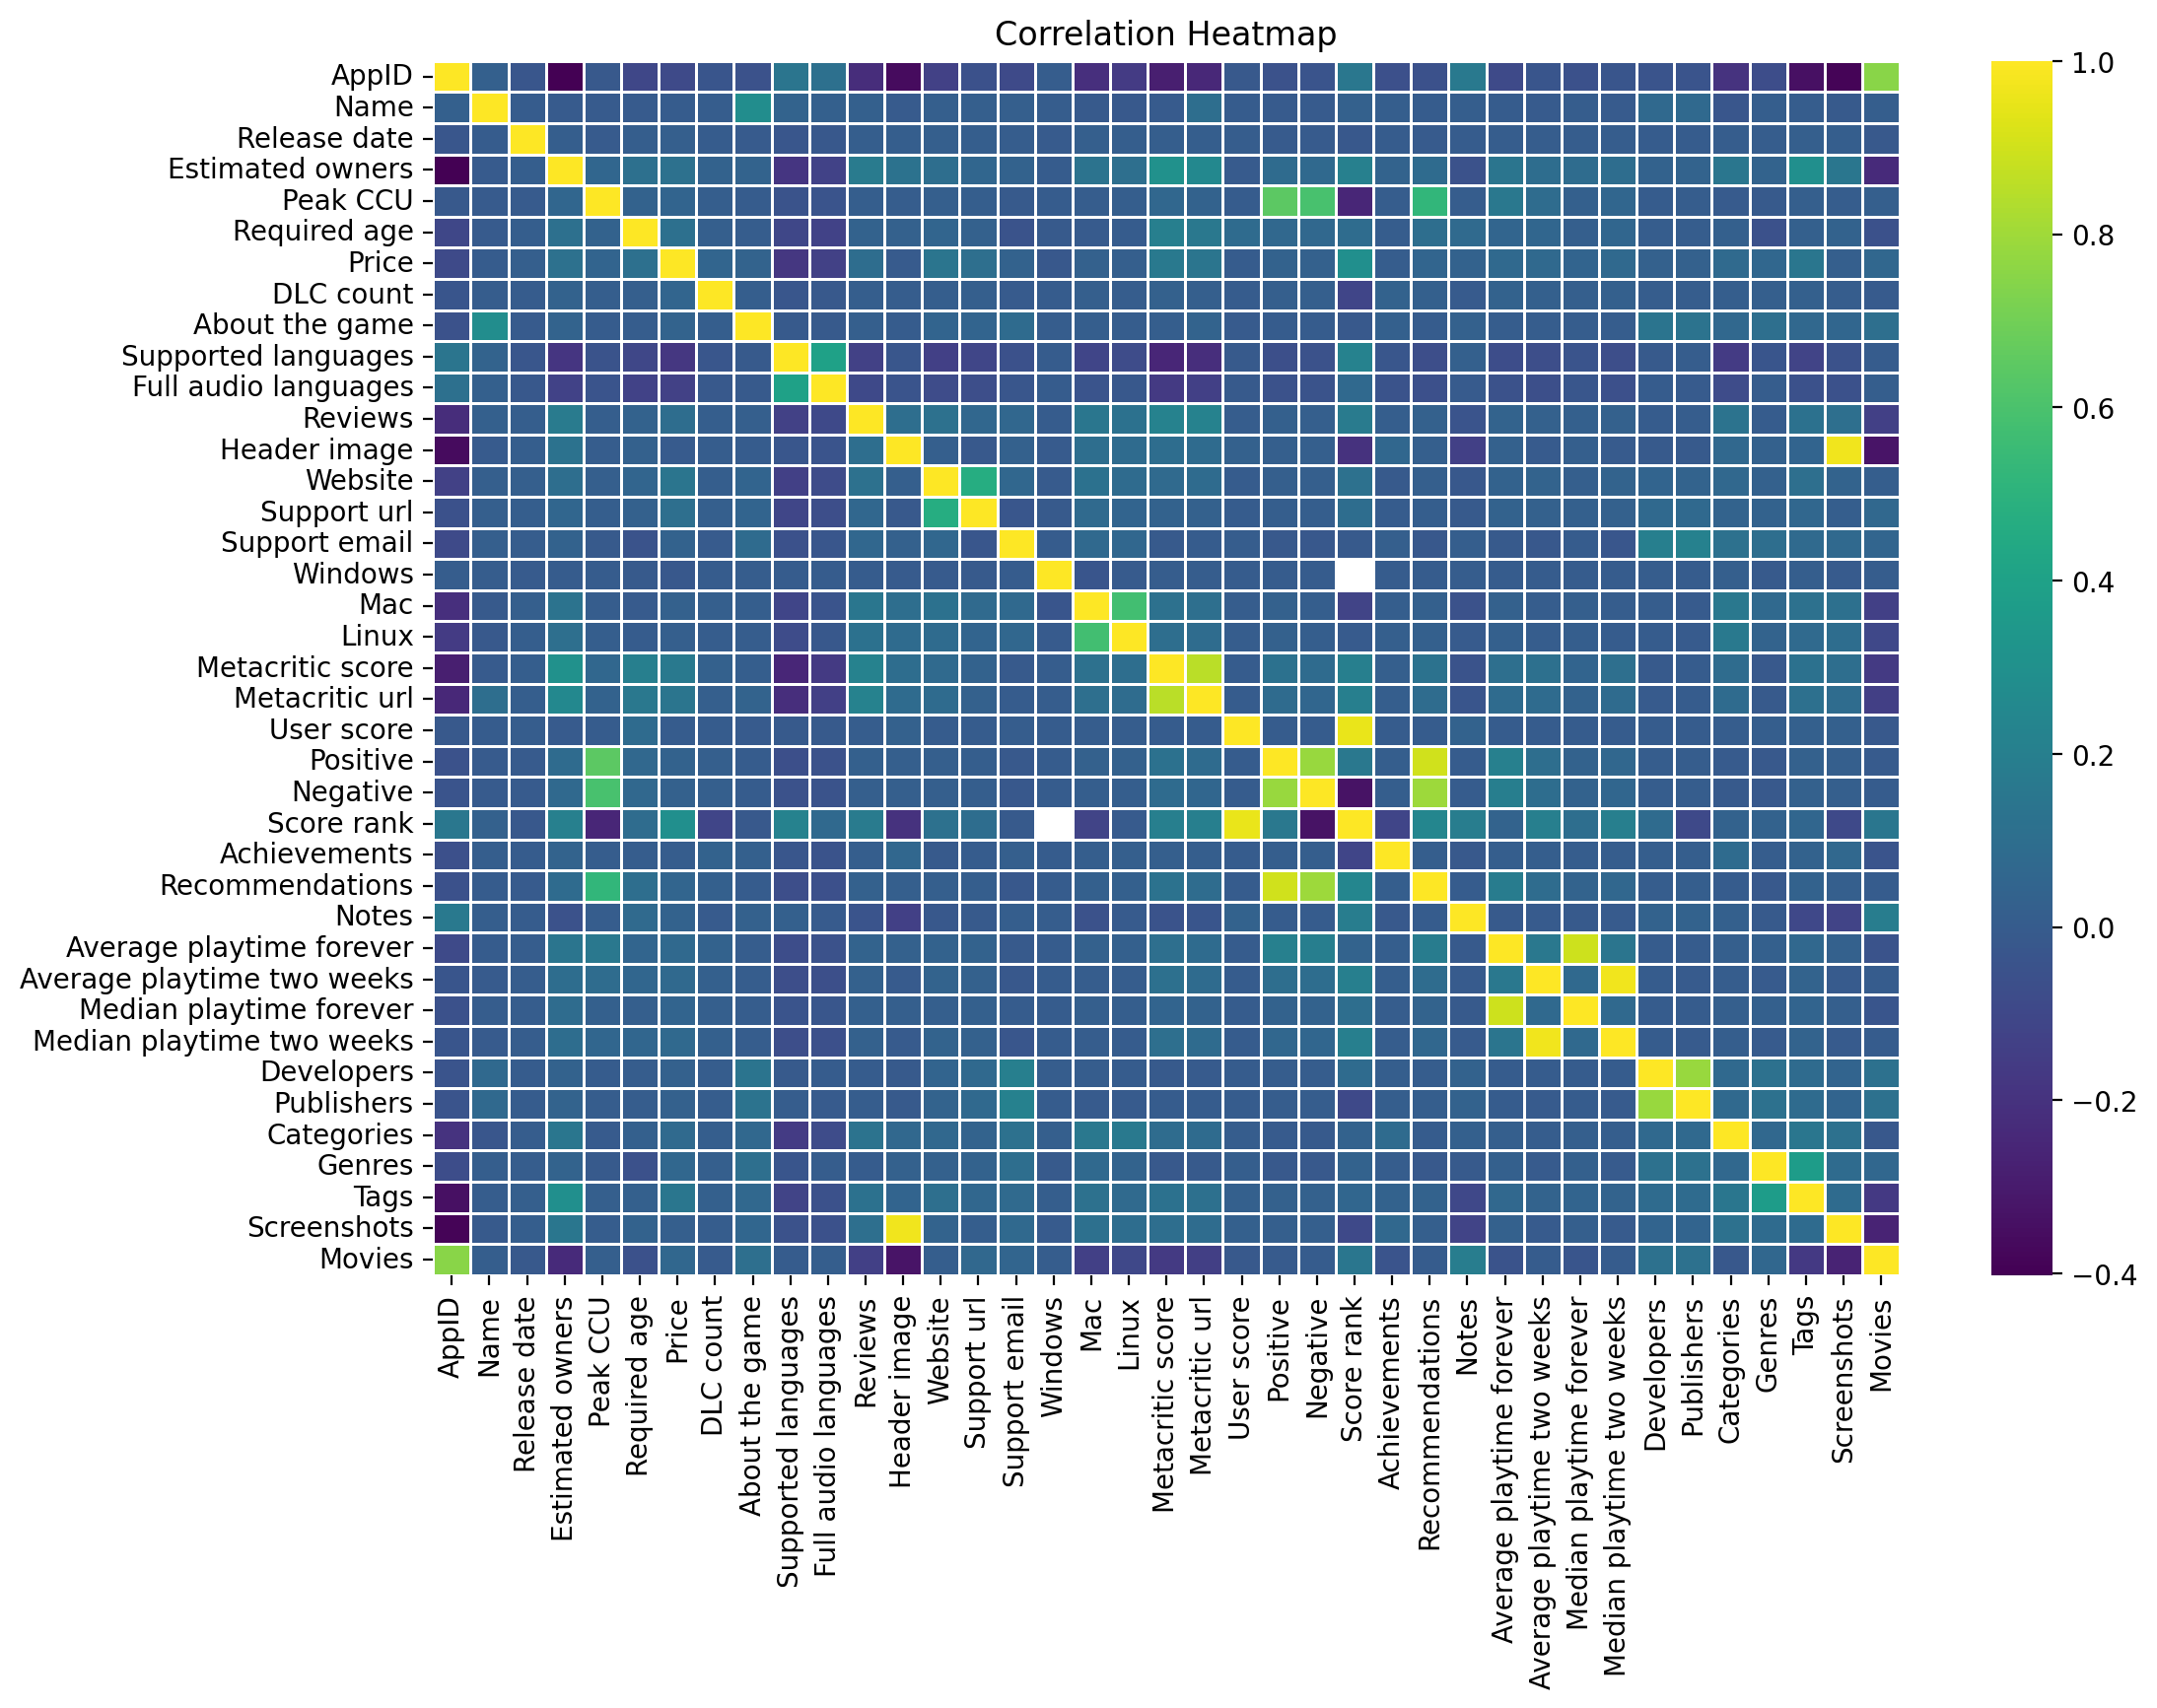

In [55]:
plt.figure(figsize=(12, 8), dpi = 200)
matrix = df
sns.heatmap(matrix.corr(), cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [56]:
# target variables (10):
# Price, Score rank, Average playtime forever, Median playtime forever, 
# Estimasted owners, Reviews, Metacritic score, User score, Positive, Negative. 

In [57]:
# List of DataFrame names
dataframe_names = [
    'Price',
    'Score rank',
    'Average playtime forever',
    'Median playtime forever',
    'Estimated owners',
    'Reviews',
    'Metacritic score',
    'User score',
    'Positive',
    'Negative'
]

# Create empty DataFrames with the correct names
dataframes = {name: pd.DataFrame() for name in dataframe_names}

# Now you can access each DataFrame by its name
Price_df = dataframes['Price']
Score_rank_df = dataframes['Score rank']
Average_playtime_df = dataframes['Average playtime forever']
Median_playtime_df = dataframes['Median playtime forever']
Estimated_owners_df = dataframes['Estimated owners']
Reviews_df = dataframes['Reviews']
Metacritic_score_df = dataframes['Metacritic score']
User_score_df = dataframes['User score']
Positive_df = dataframes['Positive']
Negative_df = dataframes['Negative']            

In [58]:
# Define the ranges (correlation with target column)
range1 = (-1, -0.40)
range2 = (0.40, 1)

Price_df = df.corr()['Price'].between(*range1) | df.corr()['Price'].between(*range2)
print("Price : ", Price_df[Price_df == True].keys(), "\n")

Score_rank_df = df.corr()['Score rank'].between(*range1) | df.corr()['Score rank'].between(*range2)
print("Score_rank : ", Score_rank_df[Score_rank_df == True].keys(), "\n")

Average_playtime_df = df.corr()['Average playtime forever'].between(*range1) | df.corr()['Average playtime forever'].between(*range2)
print("Average_playtime : ", Average_playtime_df[Average_playtime_df == True].keys(), "\n")

Median_playtime_df = df.corr()['Median playtime forever'].between(*range1) | df.corr()['Median playtime forever'].between(*range2)
print("Median playtime forever : ", Median_playtime_df[Median_playtime_df == True].keys(), "\n")

Estimated_owners_df = df.corr()['Estimated owners'].between(*range1) | df.corr()['Estimated owners'].between(*range2)
print("Estimated owners : ", Estimated_owners_df[Estimated_owners_df == True].keys(), "\n")

Reviews_df = df.corr()['Reviews'].between(*range1) | df.corr()['Reviews'].between(*range2)
print("Reviews : ", Reviews_df[Reviews_df == True].keys(), "\n")

Metacritic_score_df = df.corr()['Metacritic score'].between(*range1) | df.corr()['Metacritic score'].between(*range2)
print("Metacritic score : ", Metacritic_score_df[Metacritic_score_df == True].keys(), "\n")

User_score_df = df.corr()['User score'].between(*range1) | df.corr()['User score'].between(*range2)
print("User score : ", User_score_df[User_score_df == True].keys(), "\n")

Positive_df = df.corr()['Positive'].between(*range1) | df.corr()['Positive'].between(*range2)
print("Positive : ", Positive_df[Positive_df == True].keys(), "\n")
      
Negative_df = df.corr()['Negative'].between(*range1) | df.corr()['Negative'].between(*range2)
print("Negative : ", Negative_df[Negative_df == True].keys(), "\n")


Price :  Index(['Price'], dtype='object') 

Score_rank :  Index(['User score', 'Score rank'], dtype='object') 

Average_playtime :  Index(['Average playtime forever', 'Median playtime forever'], dtype='object') 

Median playtime forever :  Index(['Average playtime forever', 'Median playtime forever'], dtype='object') 

Estimated owners :  Index(['AppID', 'Estimated owners'], dtype='object') 

Reviews :  Index(['Reviews'], dtype='object') 

Metacritic score :  Index(['Metacritic score', 'Metacritic url'], dtype='object') 

User score :  Index(['User score', 'Score rank'], dtype='object') 

Positive :  Index(['Peak CCU', 'Positive', 'Negative', 'Recommendations'], dtype='object') 

Negative :  Index(['Peak CCU', 'Positive', 'Negative', 'Recommendations'], dtype='object') 



In [59]:
# Revert columns back to their initial dtype
for col in object_columns:
    df[col] = df_copy[col]

In [60]:
# drop unrelated
print(len(df.columns))
df = df.drop(['Header image', 'Website', 'Support url', 'Support email', 'Screenshots', 'Movies'], axis=1)
len(df.columns)

39


33

In [61]:
# Node 
def drop_columns(df):        
    df = df.drop(['Header image', 'Website', 'Support url', 'Support email', 'Screenshots', 'Movies'], axis=1)
    return df

In [62]:
# let's find if there are duplicates in the dataset 
df.duplicated().sum()

0

In [63]:
# let's find null values and by percentage 
numeric_null = numeric_columns.isnull().sum() 
print(numeric_null)
print(numeric_null / len(df) * 100)

# NOTE: only score rank from numerics,
#       fill with numeric methods

AppID                             0
Peak CCU                          0
Required age                      0
Price                             0
DLC count                         0
Metacritic score                  0
User score                        0
Positive                          0
Negative                          0
Score rank                    76945
Achievements                      0
Recommendations                   0
Average playtime forever          0
Average playtime two weeks        0
Median playtime forever           0
Median playtime two weeks         0
dtype: int64
AppID                          0.000000
Peak CCU                       0.000000
Required age                   0.000000
Price                          0.000000
DLC count                      0.000000
Metacritic score               0.000000
User score                     0.000000
Positive                       0.000000
Negative                       0.000000
Score rank                    99.945445
Achievement

In [64]:
df[df['Score rank'].notnull()].head()

AppID                                   Name  Release date  \
204    906050                    Hentai Case Opening  Sep 27, 2018   
923    371120                    Discouraged Workers  Sep 16, 2015   
1737   720380  Ancestors Legacy Free Peasant Edition   Feb 6, 2018   
2155  1014730                                  Cyndy  May 16, 2019   
2649   471720                              K Station  Jun 15, 2016   

     Estimated owners  Peak CCU  Required age  Price  DLC count  \
204         0 - 20000         1             0   0.99          0   
923         0 - 20000         1            18  14.99          8   
1737  100000 - 200000         1            17   0.00          0   
2155        0 - 20000         2            18   7.99          1   
2649        0 - 20000         0             0   0.00          0   

                                         About the game  \
204   Hentai Case Opening is a totally classic case ...   
923   Overview As a hospital coordinator, Ga-yeon fe...   
1737  Get a taste of medieval battles in this free v...   
2155  Strip 'Em II: Facka's Game launch. Please cons...   
2649  &gt; WHAT IS GOING ON?! It's New Year's Day, 2...   

                                    Supported languages  \
204                                         ['English']   
923   ['English', 'Korean', 'Spanish - Spain', 'Russ...   
1737  ['English', 'French', 'Italian', 'German', 'Sp...   
2155                                        ['English']   
2649                                        ['English']   

         Full audio languages  \
204                        []   
923                        []   
1737  ['English', 'Japanese']   
2155              ['English']   
2649                       []   

                                                Reviews  Windows    Mac  \
204                                                 NaN     True  False   
923   “Depression and anxiety aren’t often well-repr...     True   True   
1737  “Ancestors Legacy is shaping up to have just a...     True  False   
2155                                                NaN     True  False   
2649  “Kudos to the brilliant writing done in this g...     True  False   

      Linux  Metacritic score Metacritic url  User score  Positive  Negative  \
204   False                 0            NaN          63        54        29   
923    True                 0            NaN          59        61        38   
1737  False                 0            NaN          77       585       167   
2155  False                 0            NaN          68        16         6   
2649  False                 0            NaN         100        10         0   

      Score rank  Achievements  Recommendations  \
204         98.0             0              205   
923         98.0            36                0   
1737        99.0             0                0   
2155        99.0            21              197   
2649       100.0             0                0   

                                                  Notes  \
204   The pictures contained in this game show girls...   
923   Discouraged Workers contains not only sexual a...   
1737                                                NaN   
2155  This game contains adult themes and content th...   
2649                                                NaN   

      Average playtime forever  Average playtime two weeks  \
204                          0                           0   
923                        481                           0   
1737                        35                           0   
2155                       131                           0   
2649                         0                           0   

      Median playtime forever  Median playtime two weeks  \
204                         0                          0   
923                       621                          0   
1737                       59                          0   
2155                      236                          0   
2649    

In [65]:
df[df['Score rank'].isnull()].head()

AppID                   Name  Release date Estimated owners  Peak CCU  \
0    20200       Galactic Bowling  Oct 21, 2008        0 - 20000         0   
1   655370           Train Bandit  Oct 12, 2017        0 - 20000         0   
2  1732930           Jolt Project  Nov 17, 2021        0 - 20000         0   
3  1355720               Henosis™  Jul 23, 2020        0 - 20000         0   
4  1139950  Two Weeks in Painland   Feb 3, 2020        0 - 20000         0   

   Required age  Price  DLC count  \
0             0  19.99          0   
1             0   0.99          0   
2             0   4.99          0   
3             0   5.99          0   
4             0   0.00          0   

                                      About the game  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotics ...   
3  HENOSIS™ is a mysterious 2D Platform Puzzler w...   
4  ABOUT THE GAME Play as a hacker who has arrang...   

                                 Supported languages Full audio languages  \
0                                        ['English']                   []   
1  ['English', 'French', 'Italian', 'German', 'Sp...                   []   
2                 ['English', 'Portuguese - Brazil']                   []   
3  ['English', 'French', 'Italian', 'German', 'Sp...                   []   
4                     ['English', 'Spanish - Spain']                   []   

  Reviews  Windows    Mac  Linux  Metacritic score Metacritic url  User score  \
0     NaN     True  False  False                 0            NaN           0   
1     NaN     True   True  False                 0            NaN           0   
2     NaN     True  False  False                 0            NaN           0   
3     NaN     True   True   True                 0            NaN           0   
4     NaN     True   True  False                 0            NaN           0   

   Positive  Negative  Score rank  Achievements  Recommendations  \
0         6        11         NaN            30                0   
1        53         5         NaN            12                0   
2         0         0         NaN             0                0   
3         3         0         NaN             0                0   
4        50         8         NaN            17                0   

                                               Notes  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  This Game may contain content not appropriate ...   

   Average playtime forever  Average playtime two weeks  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   Median playtime forever  Median playtime two weeks             Developers  \
0                        0                          0  Perpetual FX Creative   
1                        0                          0           Rusty Moyher   
2                        0                          0          Campião Games   
3                        0                          0      Odd Critter Games   
4                        0                          0          Unusual Games   

              Publishers                                         Categories  \
0  Perpetual FX Creative  Single-player,Multi-player,Steam Achievements,...   
1           Wild Rooster  Single-player,Steam Achievements,Full controll...   
2          Campião Games                                      Single-player   
3      Odd Critter Games              Single-player,Full controller support   
4          Unusual Games                   Single

In [66]:
# let's find null values and by percentage 
objective_null = object_columns.isnull().sum() 
print(objective_null)
print(objective_null / len(df) * 100)

# NOTE: Reviews, Metacritic url, Notes, Tags to 'None'
#       maybe drop the rows with null Categories and watch if there are still null rows

Name                        2
Release date                0
Estimated owners            0
About the game           2917
Supported languages         0
Full audio languages        0
Reviews                 67625
Header image                0
Website                 40308
Support url             38763
Support email           12092
Metacritic url          73195
Notes                   65484
Developers               2941
Publishers               3205
Categories               3916
Genres                   2918
Tags                    17465
Screenshots              1618
Movies                   5618
dtype: int64
Name                     0.002598
Release date             0.000000
Estimated owners         0.000000
About the game           3.788951
Supported languages      0.000000
Full audio languages     0.000000
Reviews                 87.839505
Header image             0.000000
Website                 52.356891
Support url             50.350059
Support email           15.706548
Metacritic ur

In [67]:
# let's fix the object columns first
df[['Reviews', 'Metacritic url', 'Notes', 'Tags']] = df[['Reviews', 'Metacritic url', 'Notes', 'Tags']].replace(np.nan, 'None')

# test it 
df[['Reviews', 'Metacritic url', 'Notes', 'Tags']].isnull().sum()

Reviews           0
Metacritic url    0
Notes             0
Tags              0
dtype: int64

In [68]:
# drop numeric
df = df.dropna(subset = ['Categories', 'About the game', 'Developers', 'Publishers', 'Genres'], axis=0)
df[['Categories', 'About the game', 'Developers', 'Publishers', 'Genres']].isnull().sum()

Categories        0
About the game    0
Developers        0
Publishers        0
Genres            0
dtype: int64

In [70]:
# Numeric ones : only score rank 
print("Table with scores : ")
df[['Score rank', 'Estimated owners', 'User score', 'Positive', 'Negative']][df['Score rank'].notnull()]

# NOTE: we will drop the entire column. We cannot understand the formula. 
df =  df.drop(['Score rank'], axis=1)
df.isnull().sum()

Table with scores : 


AppID                         0
Name                          0
Release date                  0
Estimated owners              0
Peak CCU                      0
Required age                  0
Price                         0
DLC count                     0
About the game                0
Supported languages           0
Full audio languages          0
Reviews                       0
Windows                       0
Mac                           0
Linux                         0
Metacritic score              0
Metacritic url                0
User score                    0
Positive                      0
Negative                      0
Achievements                  0
Recommendations               0
Notes                         0
Average playtime forever      0
Average playtime two weeks    0
Median playtime forever       0
Median playtime two weeks     0
Developers                    0
Publishers                    0
Categories                    0
Genres                        0
Tags    

In [114]:
def datetime_format(date_string):
    # Split the date string into components
    date_parts = date_string.split()
    
    # Check if the date string has the expected number of components
    if len(date_parts) == 3:
        # Extract year, month, and day
        year = date_parts[2]
        month = date_parts[0].capitalize()  # Convert the month to uppercase
        month = strptime(f'{month}','%b').tm_mon
        day = date_parts[1]
        
        # Create a standardized date string in the format 'YYYY-MM-DD'
        formatted_date = f'{year}-{month}-{day}'
        
        return formatted_date
    else:
        # Handle cases where the date string format is unexpected
        return None

# Apply the datetime_format function to the 'Release date' column
df['Release date'] = df['Release date'].apply(datetime_format)

In [115]:
# TIME FOR DEEP DATA ENGINEERING (PER COLUMN !!!!)
# Apply the datetime_format function to the 'Release date' column
df['Release date'].head(30)

0     2008-10-21,
1     2017-10-12,
2     2021-11-17,
3      2020-7-23,
4       2020-2-3,
5      2021-2-26,
6       2022-1-9,
7       2022-5-5,
8       2020-4-2,
9     2014-11-11,
10     2019-10-2,
11      2016-7-1,
12     2021-8-27,
13      2018-4-6,
14    2020-11-25,
15    2010-11-17,
16     2020-11-6,
17     2015-2-20,
18     2019-6-20,
19     2020-7-24,
20     2016-7-28,
21     2017-1-27,
22    2017-11-20,
24     2022-7-16,
25    2020-10-10,
26     2017-8-10,
27     2021-2-16,
28     2020-7-18,
29     2020-6-19,
30      2018-3-6,
Name: Release date, dtype: object

In [ ]:
df.to_parquet('preprocessed_games.pq')

In [11]:
df = pd.read_parquet('preprocessed_games.pq')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72376 entries, 0 to 76986
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   AppID                       72376 non-null  int64         
 1   Name                        72376 non-null  object        
 2   Release date                72376 non-null  datetime64[ns]
 3   Estimated owners            72376 non-null  object        
 4   Peak CCU                    72376 non-null  int64         
 5   Required age                72376 non-null  int64         
 6   Price                       72376 non-null  float64       
 7   DLC count                   72376 non-null  int64         
 8   About the game              72376 non-null  object        
 9   Supported languages         72376 non-null  object        
 10  Full audio languages        72376 non-null  object        
 11  Reviews                     72376 non-null  object    

In [ ]:
# DATA SCIENCE SECTION 

In [ ]:
# LETS BUILD KPIS!!!!!!!!

In [7]:
                                # Usage and engagement KPIs

In [31]:
"""
A. User Engagement KPI:

User Sentiment: Use "Positive" and "Negative" reviews to determine the overall user sentiment.
"""

'\n1. User Engagement KPIs:\n\nUser Activity: Calculate the average and median playtime (forever and two weeks) to gauge user engagement.\nUser Sentiment: Use "Positive" and "Negative" reviews to determine the overall user sentiment.\n'

In [4]:
# let's create group of indexes (keys) : AppID and Name 
# values = about the game, 	Average playtime forever, Average playtime two weeks 
#          Median playtime forever, Median playtime two weeks, Positive, Negative
user_engagement = df.groupby(['AppID', 'Name']).agg(
    {'About the game' : 'first',
     'Average playtime forever' : 'first',
     'Average playtime two weeks' : 'first',
     'Median playtime forever' : 'first',
     'Median playtime two weeks' : 'first',
     'Positive' : 'first',
     'Negative' : 'first'                 
    }
)
user_engagement.head()                             

About the game  \
AppID Name                                                                           
10    Counter-Strike             Play the world's number 1 online action game. ...   
20    Team Fortress Classic      One of the most popular online action games of...   
30    Day of Defeat              Enlist in an intense brand of Axis vs. Allied ...   
40    Deathmatch Classic         Enjoy fast-paced multiplayer gaming with Death...   
50    Half-Life: Opposing Force  Return to the Black Mesa Research Facility as ...   

                                 Average playtime forever  \
AppID Name                                                  
10    Counter-Strike                                10524   
20    Team Fortress Classic                           143   
30    Day of Defeat                                  1397   
40    Deathmatch Classic                              945   
50    Half-Life: Opposing Force                       214   

                                 Average playtime two weeks  \
AppID Name                                                    
10    Counter-Strike                                   1733   
20    Team Fortress Classic                               0   
30    Day of Defeat                                       0   
40    Deathmatch Classic                                  0   
50    Half-Life: Opposing Force                           0   

                                 Median playtime forever  \
AppID Name                                                 
10    Counter-Strike                                 228   
20    Team Fortress Classic                           23   
30    Day of Defeat                                   27   
40    Deathmatch Classic                              10   
50    Half-Life: Opposing Force                       66   

                                 Median playtime two weeks  Positive  Negative  
AppID Name                                                                      
10    Counter-Strike                                   733    198387      5135  
20    Team Fortress Classic                              0      5677       923  
30    Day of Defeat                                      0      5179       566  
40    Deathmatch Classic                                 0      1929       428  
50    Half-Life: Opposing Force                          0     14333       718

In [21]:
average_user_engagement_playtime_forever = user_engagement['Average playtime forever'].mean()
print(average_user_engagement_playtime_forever)

average_user_engagement_playtime_two_weeks = user_engagement['Average playtime two weeks'].mean()
average_user_engagement_playtime_two_weeks

108.85359787774954


11.43028075605173

In [5]:
# User Sentiment: Use "Positive" and "Negative" reviews to determine the overall user sentiment.
user_engagement['Sentiment ratio'] = user_engagement['Positive'] / (user_engagement['Positive'] + user_engagement['Negative'])

# each game possesses an overall measure of user sentiment for each game, where values closer to 1 indicate highly positive sentiment, and values closer to 0 indicate negative sentiment.

In [6]:
user_engagement.head()

About the game  \
AppID Name                                                                           
10    Counter-Strike             Play the world's number 1 online action game. ...   
20    Team Fortress Classic      One of the most popular online action games of...   
30    Day of Defeat              Enlist in an intense brand of Axis vs. Allied ...   
40    Deathmatch Classic         Enjoy fast-paced multiplayer gaming with Death...   
50    Half-Life: Opposing Force  Return to the Black Mesa Research Facility as ...   

                                 Average playtime forever  \
AppID Name                                                  
10    Counter-Strike                                10524   
20    Team Fortress Classic                           143   
30    Day of Defeat                                  1397   
40    Deathmatch Classic                              945   
50    Half-Life: Opposing Force                       214   

                                 Average playtime two weeks  \
AppID Name                                                    
10    Counter-Strike                                   1733   
20    Team Fortress Classic                               0   
30    Day of Defeat                                       0   
40    Deathmatch Classic                                  0   
50    Half-Life: Opposing Force                           0   

                                 Median playtime forever  \
AppID Name                                                 
10    Counter-Strike                                 228   
20    Team Fortress Classic                           23   
30    Day of Defeat                                   27   
40    Deathmatch Classic                              10   
50    Half-Life: Opposing Force                       66   

                                 Median playtime two weeks  Positive  \
AppID Name                                                             
10    Counter-Strike                                   733    198387   
20    Team Fortress Classic                              0      5677   
30    Day of Defeat                                      0      5179   
40    Deathmatch Classic                                 0      1929   
50    Half-Life: Opposing Force                          0     14333   

                                 Negative  Sentiment ratio  
AppID Name                                                  
10    Counter-Strike                 5135         0.974769  
20    Team Fortress Classic           923         0.860152  
30    Day of Defeat                   566         0.901480  
40    Deathmatch Classic              428         0.818413  
50    Half-Life: Opposing Force       718         0.952296

In [24]:
# find the top and bottom 100 games that also have avg playtime equal or more than mean (business-wise approach)
selected_by_mean = user_engagement[(user_engagement['Average playtime forever'] >= average_user_engagement_playtime_forever) & (user_engagement['Average playtime two weeks'] >= average_user_engagement_playtime_two_weeks)]


top_100_sentiments = selected_by_mean.nlargest(100, 'Sentiment ratio')
bottom_100_sentiments = selected_by_mean.nsmallest(100, 'Sentiment ratio')

In [30]:
# test
bottom_100_sentiments.sort_values(by='Sentiment ratio', ascending=True)[:5]

About the game  \
AppID   Name                                                                    
1016950 Blood Bowl 3        Strap on your boots, don your helmet, adjust y...   
1517290 Battlefield™ 2042   WELCOME TO 2042 Battlefield™ 2042 is a first-p...   
1811260 EA SPORTS™ FIFA 23  The World’s Game EA SPORTS™ FIFA 23 brings The...   
730310  DYNASTY WARRIORS 9  Experience the thrill of one versus thousands ...   
1816570 江湖十一                A decade ago, in Bianliang capital, the five p...   

                            Average playtime forever  \
AppID   Name                                           
1016950 Blood Bowl 3                             481   
1517290 Battlefield™ 2042                       1841   
1811260 EA SPORTS™ FIFA 23                       856   
730310  DYNASTY WARRIORS 9                       215   
1816570 江湖十一                                     377   

                            Average playtime two weeks  \
AppID   Name                                             
1016950 Blood Bowl 3                               481   
1517290 Battlefield™ 2042                          232   
1811260 EA SPORTS™ FIFA 23                         856   
730310  DYNASTY WARRIORS 9                          15   
1816570 江湖十一                                       377   

                            Median playtime forever  \
AppID   Name                                          
1016950 Blood Bowl 3                            481   
1517290 Battlefield™ 2042                       937   
1811260 EA SPORTS™ FIFA 23                      886   
730310  DYNASTY WARRIORS 9                       76   
1816570 江湖十一                                    377   

                            Median playtime two weeks  Positive  Negative  \
AppID   Name                                                                
1016950 Blood Bowl 3                              481       323       910   
1517290 Battlefield™ 2042                         261     39121    106038   
1811260 EA SPORTS™ FIFA 23                        886      1997      3934   
730310  DYNASTY WARRIORS 9                         15      3075      6009   
1816570 江湖十一                                      377      1316      2517   

                            Sentiment ratio  
AppID   Name                                 
1016950 Blood Bowl 3               0.261963  
1517290 Battlefield™ 2042          0.269504  
1811260 EA SPORTS™ FIFA 23         0.336705  
730310  DYNASTY WARRIORS 9         0.338507  
1816570 江湖十一                       0.343334

In [31]:
# test 
top_100_sentiments.sort_values(by='Sentiment ratio', ascending=False)[:5]

About the game  \
AppID   Name                                                                           
2009310 Goi: Let's Play Together   Play with 3-10 players in this casual battle r...   
1144400 Senren＊Banka               Senren＊Banka is a Japanese-style visual novel ...   
1542810 Sunshine Heavy Industries  Welcome to Sunshine Heavy Industries, the newe...   
1229490 ULTRAKILL                  ULTRAKILL is a fast-paced ultraviolent old sch...   
897220  Summer Pockets             Staff Original Story: Jun Maeda Producer: Touy...   

                                   Average playtime forever  \
AppID   Name                                                  
2009310 Goi: Let's Play Together                        178   
1144400 Senren＊Banka                                    833   
1542810 Sunshine Heavy Industries                       134   
1229490 ULTRAKILL                                       793   
897220  Summer Pockets                                21112   

                                   Average playtime two weeks  \
AppID   Name                                                    
2009310 Goi: Let's Play Together                          178   
1144400 Senren＊Banka                                      332   
1542810 Sunshine Heavy Industries                          60   
1229490 ULTRAKILL                                          86   
897220  Summer Pockets                                   6700   

                                   Median playtime forever  \
AppID   Name                                                 
2009310 Goi: Let's Play Together                       178   
1144400 Senren＊Banka                                  1046   
1542810 Sunshine Heavy Industries                      134   
1229490 ULTRAKILL                                      367   
897220  Summer Pockets                               21112   

                                   Median playtime two weeks  Positive  \
AppID   Name                                                             
2009310 Goi: Let's Play Together                         178        10   
1144400 Senren＊Banka                                     332      9632   
1542810 Sunshine Heavy Industries                         60       234   
1229490 ULTRAKILL                                        115     27319   
897220  Summer Pockets                                  6700      1647   

                                   Negative  Sentiment ratio  
AppID   Name                                                  
2009310 Goi: Let's Play Together          0         1.000000  
1144400 Senren＊Banka                     80         0.991763  
1542810 Sunshine Heavy Industries         2         0.991525  
1229490 ULTRAKILL                       250         0.990932  
897220  Summer Pockets                   18         0.989189

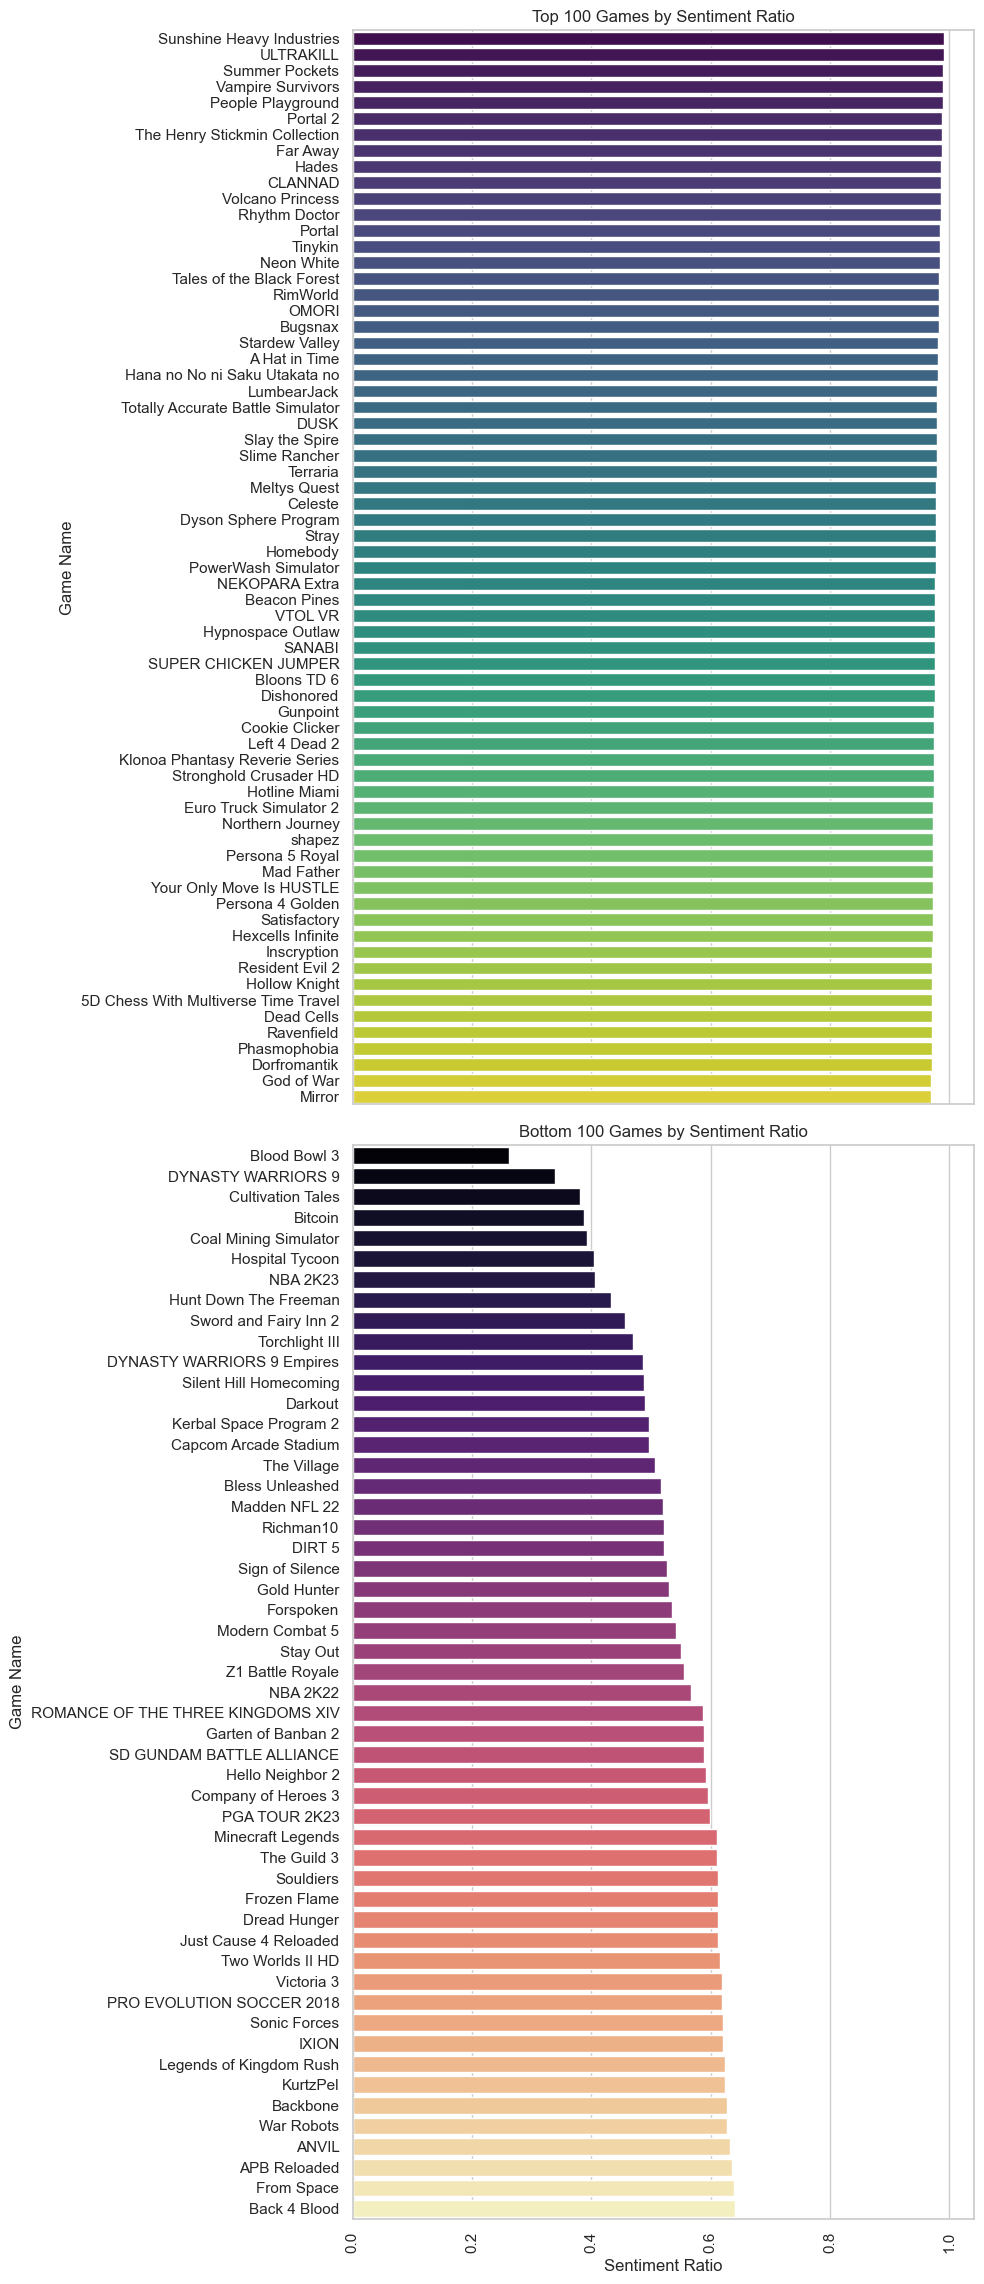

In [90]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create a single figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 23), sharex=True)

top_100_sentiments_reset = top_100_sentiments.reset_index()
bottom_100_sentiments_reset = bottom_100_sentiments.reset_index()

# present only alhanumeric english
expression = r'^[a-zA-Z0-9\s]*$'

# Create bar plots for the top and bottom 100 games with 'hue' and 'legend' parameters
sns.barplot(data=top_100_sentiments_reset[top_100_sentiments_reset['Name'].str.match(expression)], x='Sentiment ratio', y='Name', hue='Name', palette='viridis', ax=axes[0], legend=False)
sns.barplot(data=bottom_100_sentiments_reset[bottom_100_sentiments_reset['Name'].str.match(expression)], x='Sentiment ratio', y='Name', hue='Name', palette='magma', ax=axes[1], legend=False)

# Set labels and titles
axes[0].set_xlabel('Sentiment Ratio')
axes[0].set_title('Top 100 Games by Sentiment Ratio')
axes[0].set_ylabel('Game Name')
axes[1].set_xlabel('Sentiment Ratio')
axes[1].set_title('Bottom 100 Games by Sentiment Ratio')
axes[1].set_ylabel('Game Name')


# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Adjust plot layout
plt.tight_layout()

# FOR THE NODE (dont show)
# plt.savefig('BOTTOM_100.png')

# Display the plot
plt.show()

In [91]:
"""
B. Most Popular Platform metric:

Analyze the 'Peak CCU' (Concurrent Users) data to determine which platform (Windows, Mac, Linux) is the most popular for the games.
"""    


"\nB. Most Popular Platform metric:\n\nAnalyze the 'Peak CCU' (Concurrent Users) data to determine which platform (Windows, Mac, Linux) is the most popular for the games.\n"

In [107]:
 # Group by platform and calculate the total Peak CCU
platform_peak_ccu = df.groupby(['Windows', 'Mac', 'Linux'])['Peak CCU'].sum()

# Find the platform with the highest Peak CCU
most_popular_platform = platform_peak_ccu.idxmax()

# Print the results
print("Total Peak CCU by Platform:", "\n")
print(platform_peak_ccu, "\n")
print("The most popular platform is Windows !!")
most_popular_platform

Total Peak CCU by Platform: 

Windows  Mac    Linux
False    False  True           0.0
         True   False          1.0
                True           2.0
True     False  False    6956252.0
                True      112276.0
         True   False     767852.0
                True     2683104.0
Name: Peak CCU, dtype: float64 

The most popular platform is Windows !!


(True, False, False)

In [ ]:
"""
C. Metacritic Scores:

Examine the 'Metacritic score' and 'User score' columns to assess the critical and user reception of the games.
"""    

In [141]:
selected = df[(df['Metacritic score'] != 0) & (df['User score'] != 0)] 

scores = selected.groupby(['AppID', 'Name']).agg(
    {'Metacritic score' : 'sum',
     'User score' : 'sum'
    }
)
len(scores)
scores

# THERE IS NOTHING TO COMPARE HERE   

Metacritic score  User score
AppID  Name                                              
560000 Ladykiller in a Bind                73          95

In [142]:
"""
C. Language Support:

Count the number of supported languages and full audio languages to identify the games with the broadest language support.
"""

'\nC. Language Support:\n\nCount the number of supported languages and full audio languages to identify the games with the broadest language support.\n'

In [3]:
# Create a DataFrame
language_support = df.groupby(['AppID', 'Name']).agg(
    {'Supported languages': 'sum',
     'Full audio languages': 'sum'}
)
language_support.head()

Supported languages  \
AppID Name                                                                           
10    Counter-Strike             ['English', 'French', 'German', 'Italian', 'Sp...   
20    Team Fortress Classic      ['English', 'French', 'German', 'Italian', 'Sp...   
30    Day of Defeat              ['English', 'French', 'German', 'Italian', 'Sp...   
40    Deathmatch Classic         ['English', 'French', 'German', 'Italian', 'Sp...   
50    Half-Life: Opposing Force          ['English', 'French', 'German', 'Korean']   

                                                              Full audio languages  
AppID Name                                                                          
10    Counter-Strike             ['English', 'French', 'German', 'Italian', 'Sp...  
20    Team Fortress Classic                                                     []  
30    Day of Defeat                                                             []  
40    Deathmatch Classic                                                        []  
50    Half-Life: Opposing Force                                                 []

In [4]:
# create extra columns with sizes
language_support['Supported languages size'] = [len(col) for col in language_support['Supported languages']]
language_support.head()

Supported languages  \
AppID Name                                                                           
10    Counter-Strike             ['English', 'French', 'German', 'Italian', 'Sp...   
20    Team Fortress Classic      ['English', 'French', 'German', 'Italian', 'Sp...   
30    Day of Defeat              ['English', 'French', 'German', 'Italian', 'Sp...   
40    Deathmatch Classic         ['English', 'French', 'German', 'Italian', 'Sp...   
50    Half-Life: Opposing Force          ['English', 'French', 'German', 'Korean']   

                                                              Full audio languages  \
AppID Name                                                                           
10    Counter-Strike             ['English', 'French', 'German', 'Italian', 'Sp...   
20    Team Fortress Classic                                                     []   
30    Day of Defeat                                                             []   
40    Deathmatch Classic                                                        []   
50    Half-Life: Opposing Force                                                 []   

                                 Supported languages size  
AppID Name                                                 
10    Counter-Strike                                  116  
20    Team Fortress Classic                           127  
30    Day of Defeat                                    61  
40    Deathmatch Classic                              127  
50    Half-Life: Opposing Force                        41

In [5]:
# create extra columns with sizes
language_support['Full audio languages size'] = [len(col) for col in language_support['Full audio languages']]
language_support.head()

Supported languages  \
AppID Name                                                                           
10    Counter-Strike             ['English', 'French', 'German', 'Italian', 'Sp...   
20    Team Fortress Classic      ['English', 'French', 'German', 'Italian', 'Sp...   
30    Day of Defeat              ['English', 'French', 'German', 'Italian', 'Sp...   
40    Deathmatch Classic         ['English', 'French', 'German', 'Italian', 'Sp...   
50    Half-Life: Opposing Force          ['English', 'French', 'German', 'Korean']   

                                                              Full audio languages  \
AppID Name                                                                           
10    Counter-Strike             ['English', 'French', 'German', 'Italian', 'Sp...   
20    Team Fortress Classic                                                     []   
30    Day of Defeat                                                             []   
40    Deathmatch Classic                                                        []   
50    Half-Life: Opposing Force                                                 []   

                                 Supported languages size  \
AppID Name                                                  
10    Counter-Strike                                  116   
20    Team Fortress Classic                           127   
30    Day of Defeat                                    61   
40    Deathmatch Classic                              127   
50    Half-Life: Opposing Force                        41   

                                 Full audio languages size  
AppID Name                                                  
10    Counter-Strike                                   116  
20    Team Fortress Classic                              2  
30    Day of Defeat                                      2  
40    Deathmatch Classic                                 2  
50    Half-Life: Opposing Force                          2

In [4]:
df.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Achievements', 'Recommendations', 'Notes',
       'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags'],
      dtype='object')

In [5]:
"""
D. PLAYTIME (User engagement) :

Identify games with exceptionally high average playtime.
"""

'\nD. PLAYTIME (User engagement) :\n\nIdentify games with exceptionally high or low average playtime.\n'

In [3]:
# Note 8 data Science all the way down 
# so let's group the games with playtime  
average_playtime = df.groupby(['Average playtime forever']).agg(
    { 
      'Average playtime two weeks' : 'sum',
      'Name': 'first', 
      'Categories': 'first',
      'Genres': 'first'   
    }
)

median_playtime = df.groupby(['Median playtime forever']).agg(  
    {
      'Median playtime two weeks' : 'sum',
      'Name': 'first', 
      'Categories': 'first',
      'Genres': 'first'   
    }
)

In [4]:
# let's find out the top 100 by average playtime 
top_100_average_playtime = average_playtime.sort_values(by='Average playtime forever', ascending=False).head(100)
top_100_average_playtime.head()

Average playtime two weeks                   Name  \
Average playtime forever                                                      
90351                                              0  副作用之瞳-Tlicolity Eyes-   
76068                                              0        Defense Clicker   
68357                                              0                 Relive   
68159                                              0        Sisyphus Reborn   
51388                                              0     WARRIORS ALL-STARS   

                                                                 Categories  \
Average playtime forever                                                      
90351                                                         Single-player   
76068                     Single-player,Steam Achievements,Steam Cloud,S...   
68357                                      Single-player,Steam Achievements   
68159                                      Single-player,Steam Achievements   
51388                     Single-player,Steam Achievements,Steam Trading...   

                                                     Genres  
Average playtime forever                                     
90351                     Adventure,Casual,Free to Play,RPG  
76068                          Casual,Strategy,Early Access  
68357                          Adventure,Free to Play,Indie  
68159                                             Adventure  
51388                                                Action

In [5]:
# let's find out the top 100 by median playtime
top_100_median_playtime = median_playtime.sort_values(by='Median playtime forever', ascending=False).head(100)
top_100_median_playtime.head()

Median playtime two weeks  \
Median playtime forever                              
136629                                           0   
136291                                           0   
102435                                           0   
99108                                            0   
90351                                            0   

                                                    Name  \
Median playtime forever                                    
136629                                            Relive   
136291                                   Sisyphus Reborn   
102435                                WARRIORS ALL-STARS   
99108                    拯救大魔王2 Rescue the Great Demon 2   
90351                              副作用之瞳-Tlicolity Eyes-   

                                                                Categories  \
Median playtime forever                                                      
136629                                    Single-player,Steam Achievements   
136291                                    Single-player,Steam Achievements   
102435                   Single-player,Steam Achievements,Steam Trading...   
99108                                    Single-player,Steam Trading Cards   
90351                                                        Single-player   

                                                    Genres  
Median playtime forever                                     
136629                        Adventure,Free to Play,Indie  
136291                                           Adventure  
102435                                              Action  
99108                     Adventure,Free to Play,Indie,RPG  
90351                    Adventure,Casual,Free to Play,RPG

In [6]:
# NLP FOR AVERAGE PLAYTIME 
# Extract 'Categories' and 'Genres' columns
categories_genres_text = top_100_average_playtime[['Categories', 'Genres']]

# Combine 'Categories' and 'Genres' into a single text column
text_data_avg = categories_genres_text['Categories'] + ' ' + categories_genres_text['Genres']

In [7]:
# NLP FOR MEDIAN PLAYTIME 
# Extract 'Categories' and 'Genres' columns
categories_genres_text = top_100_median_playtime[['Categories', 'Genres']]

# Combine 'Categories' and 'Genres' into a single text column
text_data_median = categories_genres_text['Categories'] + ' ' + categories_genres_text['Genres']

In [8]:
def extract_keywords(text):
    # Define a regular expression pattern to match words
    pattern = r'\b\w+\b'
    keywords = re.findall(pattern, text)
    return ' '.join(keywords)

In [9]:
def receive_data(text_data):

    # Apply the keyword extraction function to the text data
    text_data = text_data.apply(extract_keywords)

    # Create an NLP dataframe with keywords
    count_vectorizer = CountVectorizer()
    keywords_matrix = count_vectorizer.fit_transform(text_data)

    # Create a DataFrame with keywords as columns
    nlp_df = pd.DataFrame(keywords_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
    return nlp_df

# Now, 'nlp_df' contains a dataframe with keywords extracted from 'Categories' and 'Genres' of the top N games with the most playtime.

In [10]:
nlp_data_avg = receive_data(text_data_avg)
nlp_data_median = receive_data(text_data_median)

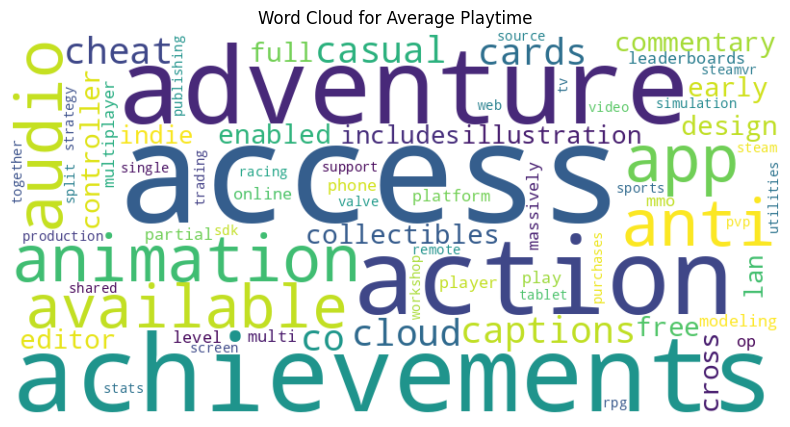

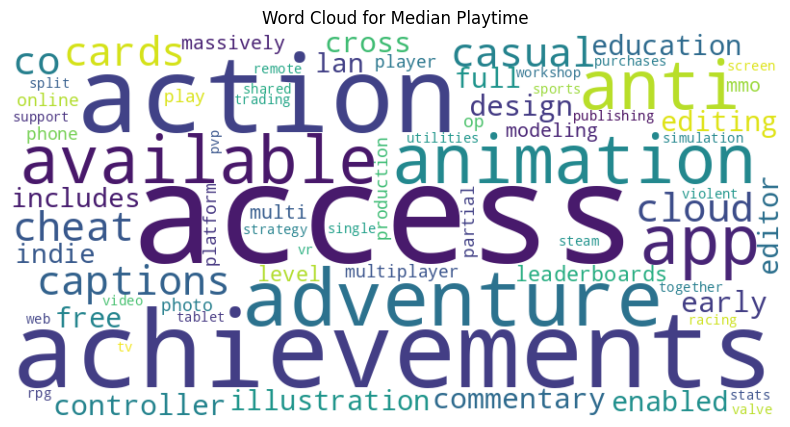

In [11]:
# Define a function to generate and display a word cloud
def generate_word_cloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Generate and display word clouds for 'Average Playtime' and 'Median Playtime' data
generate_word_cloud(' '.join(nlp_data_avg.columns), "Word Cloud for Average Playtime")
generate_word_cloud(' '.join(nlp_data_median.columns), "Word Cloud for Median Playtime")

In [17]:
"""
E. Monetization Analysis :

Examine the distribution of game prices.
"""

'\nE. Monetization Analysis :\n\nExamine the distribution of game prices.\n'

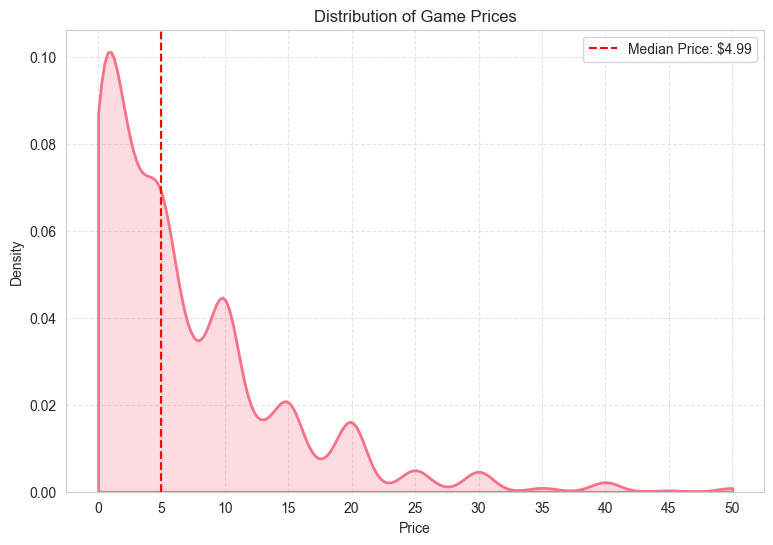

In [29]:
# Node 9 data Science all the way down 
# Set the style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("husl")

# Create a figure and axes
fig, ax = plt.subplots(figsize=(9, 6), dpi=100)

# Create a KDE plot with custom settings
sns.kdeplot(data=df, x='Price', clip=[0, 50], fill=True, ax=ax, linewidth=2)

# Add a vertical line for the median price
median_price = df['Price'].median()
ax.axvline(median_price, color='red', linestyle='--', label=f'Median Price: ${median_price:.2f}')

# Set labels and title
ax.set_xlabel('Price')
ax.set_ylabel('Density')
ax.set_title('Distribution of Game Prices')

# Add legend
ax.legend()

# Display a fancy grid background
ax.grid(True, linestyle='--', alpha=0.5)

# Customize the x-axis ticks
custom_ticks = np.arange(0, 51, 5)  # Customize as needed
ax.set_xticks(custom_ticks)

# fig.savefig('Distribution_of_Game_Prices.png')

# Show the plot
plt.show()

In [30]:
"""
F. Monetization Analysis :

Analyze the correlation between price and user engagement metrics.
"""

'\nF. Monetization Analysis :\n\nAnalyze the correlation between price and user engagement metrics.\n'

In [21]:
df['DLC count'].head()

0    0
1    0
2    0
3    0
4    0
Name: DLC count, dtype: int64

In [22]:
# Create a scatter plot of Price vs. User Score
# Import necessary libraries

# Spearman correlation is used when the data is not normally distributed or has outliers.
# Compute Spearman correlation between Price and Playtime
listed = ['Price', 'Positive', 'Negative', 'Recommendations', 'Peak CCU']

spearman_corr, _ = spearmanr(df['Price'], df['Estimated owners'])
print(f"Spearman Correlation between Price and Owners: {spearman_corr:.2f}")

spearman_corr, _ = spearmanr(df['DLC count'], df['Estimated owners'])
print(f"Spearman Correlation between DLC count and Owners: {spearman_corr:.2f}")

spearman_corr, _ = spearmanr(df['Positive'], df['Estimated owners'])
print(f"Spearman Correlation between Positive and Owners: {spearman_corr:.2f}")

spearman_corr, _ = spearmanr(df['Negative'], df['Estimated owners'])
print(f"Spearman Correlation between Negative and Owners: {spearman_corr:.2f}")

spearman_corr, _ = spearmanr(df['Recommendations'], df['Estimated owners'])
print(f"Spearman Correlation between Recommendations and Owners: {spearman_corr:.2f}")

spearman_corr, _ = spearmanr(df['Peak CCU'], df['Estimated owners'])
print(f"Spearman Correlation between Peak CCU and Owners: {spearman_corr:.2f}")

Spearman Correlation between Price and Owners: 0.20
Spearman Correlation between DLC count and Owners: 0.22
Spearman Correlation between Positive and Owners: 0.67
Spearman Correlation between Negative and Owners: 0.65
Spearman Correlation between Recommendations and Owners: 0.53
Spearman Correlation between Peak CCU and Owners: 0.46


In [40]:
"""
G. Monetization Analysis :

Investigate the influence of DLC count on user engagement (estimated owners and positive comments).
"""

'\nG. Monetization Analysis :\n\nInvestigate the influence of DLC count on user engagement and scores.\n'

In [21]:
# Create an interactive scatter plot
fig = px.scatter(
    df,
    x='DLC count',
    y='Positive',
    color='Estimated owners',
    title='DLC Count vs. Positive Comments with Estimated Owners as Hue',
    labels={'DLC count': 'DLC Count', 'Positive': 'Positive Comments', 'Estimated owners': 'Estimated Owners'},
    hover_name='Name',
    color_continuous_scale='Viridis',
)

# Customize the hover information
fig.update_traces(marker=dict(size=5))

# Limit the x and y axis ranges
fig.update_xaxes(range=[0, 100], title_text='DLC Count')
fig.update_yaxes(range=[0, 500000], title_text='Positive Comments')

# Set the color scale title
fig.update_coloraxes(colorbar_title='Estimated Owners')

# Add axis labels
fig.update_layout(xaxis=dict(title='DLC Count', title_font=dict(size=14)),
                  yaxis=dict(title='Positive Comments', title_font=dict(size=14)))

# Customize the layout
fig.update_layout(autosize=False, width=800, height=500)

# fig.savefig('DLC Count vs. Positive Comments with Estimated Owners as Hue.png')

# Show the interactive plot
fig.show()


# NOTE : IT SEEMS THAT THE LESS DLC THE MORE THE POSITIVE COMMENTS AND THE OWNERS 
#      : <= 20 DLC SEEMS TO BE THE SWEET SPOT

In [ ]:
                                    # OUTLIERS BEFORE ANYTHING (ANOMALY DETECTION)     
                                    
# lets create a dataframe containing the following features :
testing_data = df[['Peak CCU', 'Recommendations', 'Positive', 'Negative', 'Price']]                                                                    
testing_data.head()

In [115]:
                                    # OUTLIERS BEFORE ANYTHING (ANOMALY DETECTION)
                                    
# the dataset is multivariate . let's try ISOLATION FOREST WITH multiple estimators
# AND MEASURE PERFORMANCE WITH LINEAR REGRESSION MODEL to find the ideal one
 
def evaluate_outlier_classifier(model, data, threshold=.75):
    
    model.fit(data)

    probs = model.predict_proba(data)
    inliers = data[probs[:, 1] <= threshold]

    return inliers

def evaluate_regressor(inliers):
    
    X, y = inliers.drop("Price", axis=1), inliers[['Price']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7)    

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    preds = lr.predict(X_test)
    mse = mean_squared_error(y_test, preds, squared=False) # measuring with mean squared error

    return round(mse, 3) 

In [119]:
                                    # OUTLIERS BEFORE ANYTHING (ANOMALY DETECTION)

estimators = [100, 200, 300, 400, 500] # the exact number of trees
max_samples = [0.6, 0.8, 1] # trains its iTrees on n% of the rows
scores = dict() 

# HYPERPARAMETER TUNING 
for e, m in product(estimators, max_samples):
    iforest = IForest(n_estimators=e, max_samples=m, n_jobs=-1) # njobs -1 = ALL CPUs USED 
    
    inliers = evaluate_outlier_classifier(iforest, testing_data)
    scores[(e, m)] = evaluate_regressor(inliers)

print(scores, "\n")    
print(min(scores.items(), key=operator.itemgetter(1))[0])

# NOTE : 200 ESTIMATORS WITH 80% OF SAMPLES

{(100, 0.6): 11.73, (100, 0.8): 9.795, (100, 1): 9.576, (200, 0.6): 9.895, (200, 0.8): 9.553, (200, 1): 9.576, (300, 0.6): 10.026, (300, 0.8): 10.38, (300, 1): 9.576, (400, 0.6): 9.765, (400, 0.8): 10.38, (400, 1): 9.576, (500, 0.6): 9.871, (500, 0.8): 10.38, (500, 1): 9.576} 

(200, 0.8)


In [120]:
                                    # OUTLIERS BEFORE ANYTHING (ANOMALY DETECTION)

iforest = IForest(n_estimators=200, max_samples=0.8, random_state=42)
iforest.fit(testing_data)

probs = iforest.predict_proba(testing_data)

outliers_probs = probs[:, 1] # from 2-d array.....
outliers = testing_data[outliers_probs >= 0.65]

print("IForest outliers (WITH PROBABILITIES) in testing data: ", len(outliers))
print("Size of testing data                                 : ", len(testing_data))
print("IForest outliers in testing data percentage          : ", round(len(outliers) / len(testing_data) * 100, 2), "%")                                    

IForest outliers (WITH PROBABILITIES) in testing data:  32
Size of testing data                                 :  72376
IForest outliers in testing data percentage          :  0.04 %


In [ ]:
                                    # OUTLIERS BEFORE ANYTHING (ANOMALY DETECTION)
# REMOVE THEM
testing_data = testing_data[~testing_data.isin(outliers)].dropna() 
len(testing_data) 

In [122]:
testing_data.to_csv('testing_data.csv')

In [2]:
testing_data = pd.read_csv('testing_data.csv').drop('Unnamed: 0', axis=1)
testing_data.head()

Peak CCU  Recommendations  Positive  Negative  Price
0       0.0              0.0       6.0      11.0  19.99
1       0.0              0.0      53.0       5.0   0.99
2       0.0              0.0       0.0       0.0   4.99
3       0.0              0.0       3.0       0.0   5.99
4       0.0              0.0      50.0       8.0   0.00

In [ ]:
                                    # AB TESTING (TRADITIONAL)

# A/B Test: Pricing Strategy

# Version A = current price
# Version B = current price increased by 5%

# Hypothesis:

# Null Hypothesis (H0): There is no significant difference in user engagement between the current pricing strategy 
# and the new pricing strategy (increase price by 5%).

# Alternative Hypothesis (H1): There is a significant difference in user engagement between the current pricing strategy 
# and the new pricing strategy (increase price by 5%).     

In [3]:
                                    # AB TESTING (TRADITIONAL)
                                    
                                                                        
np.random.seed(42)
control_group = testing_data.sample(frac=0.5, random_state=42)

experimental_group = testing_data[~testing_data.index.isin(control_group.index)].copy()
experimental_group['Price'] = experimental_group['Price'] * 1.05

experimental_group.head()

Peak CCU  Recommendations  Positive  Negative    Price
2        0.0              0.0       0.0       0.0   5.2395
5       68.0              0.0      87.0      49.0   0.0000
8        1.0              0.0      76.0       6.0  15.7395
10       5.0            427.0     589.0     212.0  25.1895
12       0.0              0.0       5.0       0.0   2.0895

In [5]:
                                    # AB TESTING (TRADITIONAL)

# SANITY CHECK 

# A. SIZE OF SAMPLES  
print("Size of control group      : ", len(control_group))
print("Size of experimental group : ", len(experimental_group))

# B. DISTRIBUTION CHECK

# Function to perform Shapiro-Wilk test
def shapiro_test(column_data):
    stat, p_value = shapiro(column_data)
    return stat, p_value

# Number of parallel jobs
n_jobs = -1  # Set to the number of available CPU cores, or -1 for all cores

# Perform Shapiro-Wilk test for normality in parallel
results = Parallel(n_jobs=n_jobs)(
    delayed(shapiro_test)(control_group[column]) for column in control_group.columns
)

# Display results
for column, (stat, p_value) in zip(control_group.columns, results):
    print(f"Shapiro-Wilk test for normality ({column}): W={stat}, p-value={p_value}")
    
""" 
Shapiro-Wilk test for normality (Peak CCU):
W statistic: 0.028274476528167725
p-value: 0.0
Interpretation: The p-value is very close to zero, indicating strong evidence against the null hypothesis that the data is normally distributed. In practical terms, the distribution of "Peak CCU" is likely not normal.

Shapiro-Wilk test for normality (Recommendations):
W statistic: 0.06347024440765381
p-value: 0.0
Interpretation: Similar to the first case, the p-value is very close to zero, suggesting strong evidence against normality for the "Recommendations" column.


Shapiro-Wilk test for normality (Positive):
W statistic: 0.06347119808197021
p-value: 0.0
Interpretation: The p-value is again very close to zero, indicating a departure from normality for the "Positive" column.


Shapiro-Wilk test for normality (Negative):
W statistic: 0.07963860034942627
p-value: 0.0
Interpretation: The p-value is close to zero, suggesting that the "Negative" column is not normally distributed.


Shapiro-Wilk test for normality (Price):
W statistic: 0.6101589202880859
p-value: 0.0
Interpretation: While the p-value is still very low, the W statistic is higher compared to the other cases. This might indicate a departure from normality, but less pronounced compared to the other columns.
"""

Size of control group      :  36172
Size of experimental group :  36172
Shapiro-Wilk test for normality (Peak CCU): W=0.028274476528167725, p-value=0.0
Shapiro-Wilk test for normality (Recommendations): W=0.06347024440765381, p-value=0.0
Shapiro-Wilk test for normality (Positive): W=0.06347119808197021, p-value=0.0
Shapiro-Wilk test for normality (Negative): W=0.07963860034942627, p-value=0.0
Shapiro-Wilk test for normality (Price): W=0.6101589202880859, p-value=0.0


' \nShapiro-Wilk test for normality (Peak CCU):\nW statistic: 0.028274476528167725\np-value: 0.0\nInterpretation: The p-value is very close to zero, indicating strong evidence against the null hypothesis that the data is normally distributed. In practical terms, the distribution of "Peak CCU" is likely not normal.\n\nShapiro-Wilk test for normality (Recommendations):\nW statistic: 0.06347024440765381\np-value: 0.0\nInterpretation: Similar to the first case, the p-value is very close to zero, suggesting strong evidence against normality for the "Recommendations" column.\n\n\nShapiro-Wilk test for normality (Positive):\nW statistic: 0.06347119808197021\np-value: 0.0\nInterpretation: The p-value is again very close to zero, indicating a departure from normality for the "Positive" column.\n\n\nShapiro-Wilk test for normality (Negative):\nW statistic: 0.07963860034942627\np-value: 0.0\nInterpretation: The p-value is close to zero, suggesting that the "Negative" column is not normally distri

In [7]:
                                    # AB TESTING (TRADITIONAL)
                                    
# WE SHOULD USE NON-PARAMETRIC TESTS FOR SMALL SAMPLE SIZES AND DATA NOT NORMALLY DISTRIBUTED !!!!!!!!

a = 0.05 # significance level

# For non-parametric tests like the Mann-Whitney U test, constructing a confidence interval for the median difference is not as straightforward
# as with parametric tests like the t-test. The median difference is often reported alongside the p-value, 
# but constructing a confidence interval for it might require specialized methods, such as bootstrapping.

# Mann-Whitney U Test (for Independent Samples):

for column in control_group.columns:
    # Run a two-sided Wilcoxon-Mann-Whitney test
    wmw_test = pg.mwu(x=control_group[column], y=experimental_group[column], alternative='two-sided')

    # Calculate bootstrapped confidence interval for the median difference
    median_diff_ci = pg.compute_bootci(control_group[column] - experimental_group[column], func='std', method='cper', confidence=1-a)

    # Check for NaN values in the confidence interval
    if np.isnan(median_diff_ci).any():
        print(f"Mann-Whitney U test for {column}:\n", wmw_test)
        print("Median Difference CI: Unable to compute (NaN values)\n")
    else:
        # Print the test results
        print(f"Mann-Whitney U test for {column}:\n", wmw_test)
        print(f"Median Difference CI: {median_diff_ci}\n")

Mann-Whitney U test for Peak CCU:
            U-val alternative     p-val       RBC      CLES
MWU  655780900.0   two-sided  0.480126 -0.002406  0.501203
Median Difference CI: Unable to compute (NaN values)

Mann-Whitney U test for Recommendations:
            U-val alternative     p-val       RBC      CLES
MWU  656461751.5   two-sided  0.227063 -0.003447  0.501723
Median Difference CI: Unable to compute (NaN values)

Mann-Whitney U test for Positive:
            U-val alternative     p-val       RBC      CLES
MWU  653664133.5   two-sided  0.845897  0.000829  0.499585
Median Difference CI: Unable to compute (NaN values)

Mann-Whitney U test for Negative:
            U-val alternative     p-val       RBC      CLES
MWU  652977813.5   two-sided  0.654479  0.001879  0.499061
Median Difference CI: Unable to compute (NaN values)

Mann-Whitney U test for Price:
            U-val alternative         p-val       RBC      CLES
MWU  626374053.0   two-sided  3.136792e-23  0.042544  0.478728
Median 

In [ ]:
                                    # AB TESTING (TRADITIONAL)
"""
Interpretation:

Peak CCU:
p-value: 0.480126
Conclusion: Fail to reject the null hypothesis. There is no significant difference in Peak CCU between the two pricing strategies.
Recommendations:

Recommendations:
p-value: 0.227063
Conclusion: Fail to reject the null hypothesis. There is no significant difference in Recommendations between the two pricing strategies.
Positive:

Positive:
p-value: 0.845897
Conclusion: Fail to reject the null hypothesis. There is no significant difference in Positive engagement between the two pricing strategies.
Negative:

Negative:
p-value: 0.654479
Conclusion: Fail to reject the null hypothesis. There is no significant difference in Negative engagement between the two pricing strategies.
Price:

Price
p-value: 3.136792e-23
Conclusion: Reject the null hypothesis. There is a significant difference in Price between the two pricing strategies. The increase in price by 5% has a statistically significant impact.
"""

In [16]:
                                    # PREDICTIVE MODELING FOR PRICE  


# make them numeric 

# Set the batch size
batch_size = 100

# Encode in batches
object_columns = df.select_dtypes(include='object')

for i in range(0, len(object_columns.columns), batch_size):
    batch_columns = object_columns.iloc[:, i:i+batch_size]

    # Apply label encoding to each column in the batch
    for column in batch_columns.columns:
        label_encoder = LabelEncoder()
        df[column] = df[column].astype(str)  # Ensure data type is string
        df[column] = label_encoder.fit_transform(df[column])

print("DataFrame after label encoding in batches:")
print(df.head())

DataFrame after label encoding in batches:
     AppID   Name Release date  Estimated owners  Peak CCU  Required age  \
0    20200  23281   2008-10-21                 1         0             0   
1   655370  62685   2017-10-12                 1         0             0   
2  1732930  30579   2021-11-17                 1         0             0   
3  1355720  26613   2020-07-23                 1         0             0   
4  1139950  63526   2020-02-03                 1         0             0   

   Price  DLC count  About the game  Supported languages  \
0  19.99          0           24448                 9681   
1   0.99          0           51537                 3819   
2   4.99          0           34008                 7750   
3   5.99          0           26504                 3665   
4   0.00          0            5982                 9490   

   Full audio languages  Reviews  Windows    Mac  Linux  Metacritic score  \
0                  2014      286     True  False  False       

In [17]:
                                    # PREDICTIVE MODELING FOR PRICE
                                    
df = df.drop('Release date', axis=1)                                    

In [18]:
                                    # PREDICTIVE MODELING FOR PRICE  
                                    
# 1. DIMENSIONALITY REDUCTION 

scaler = StandardScaler()
# standardize the Data
scaled_X = scaler.fit_transform(df)

explained_variance = []

# Update the loop range to len(df.columns) + 1 
for n in range(1, len(df.columns) + 1):
    pca = PCA(n_components=n)
    pca.fit(scaled_X)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

data_variance = pd.DataFrame(dict(num_of_components=range(1, len(df.columns) + 1),
                                   variance=explained_variance))

print(data_variance.sort_values(by='variance', ascending=True))

fig = px.line(x=range(1, len(df.columns) + 1), y=explained_variance, 
              labels={'x': 'Num of Components', 'y': 'Variance Explained'},
              title='Variance Explained by Number of Components')

fig.show()

# NOTE : using around 25 components explains around 97.3% of the variance. !!!!!!!!

    num_of_components  variance
0                   1  0.117898
1                   2  0.203740
2                   3  0.266685
3                   4  0.324781
4                   5  0.378497
5                   6  0.428708
6                   7  0.474169
7                   8  0.516568
8                   9  0.554187
9                  10  0.590394
10                 11  0.624381
11                 12  0.656924
12                 13  0.689391
13                 14  0.721090
14                 15  0.751746
15                 16  0.781008
16                 17  0.809632
17                 18  0.836861
18                 19  0.863007
19                 20  0.885312
20                 21  0.906732
21                 22  0.925813
22                 23  0.943097
23                 24  0.959343
24                 25  0.972893
25                 26  0.980705
26                 27  0.988172
27                 28  0.992621
28                 29  0.996445
29                 30  0.999039
30      

In [3]:
                                    # PREDICTIVE MODELING FOR PRICE  
                                    
# 1. DIMENSIONALITY REDUCTION with pycaret

clf1 = setup(data = df, target = 'Price', pca = True, pca_components = 25, session_id = 42, n_jobs=-1)

In [7]:
                                    # PREDICTIVE MODELING FOR PRICE  

# 2. REGRESSION MODEL 
# compare models

best = compare_models()
print(best)

Initiated  . . . . . . . . . . . . . . . . . .           01:13:06
Status     . . . . . . . . . . . . . . . . . .  Loading Estimator
Estimator  . . . . . . . . . . . . . . . . . .  Linear Regression

ExtraTreesRegressor(n_jobs=-1, random_state=42)


In [8]:
# PREDICTIVE MODELING FOR PRICE  

# 2. REGRESSION MODEL 

best_model = create_model(best)  

# choose_better=True param to have the original model returned if the tuned one performs worse.  
tuned_model = tune_model(best_model, choose_better = True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [20]:
model_filename = 'price_regression_model.pkl'

# Save the model
joblib.dump(tuned_model, model_filename)

In [4]:
model_loaded = joblib.load('price_regression_model.pkl')

In [5]:
# PREDICTIVE MODELING FOR PRICE  

# 2. REGRESSION MODEL 

evaluate_model(model_loaded)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# PREDICTIVE MODELING FOR PRICE  

# 2. REGRESSION MODEL 
predictions = predict_model(model_loaded) # creates dataframe with prediction label added to the initial dataframe 
predictions.head()

In [11]:
                                    # CONTAINERIZATION 
                                                                         
# create api
create_api(model_loaded, 'model_loaded_api')

# create docker
create_docker('model_loaded_api')

API successfully created. This function only creates a POST API, it doesn't run it automatically. To run your API, please run this command --> !python model_loaded_api.py
Writing requirements.txt
Writing Dockerfile
Dockerfile and requirements.txt successfully created.
    To build image you have to run --> !docker image build -f "Dockerfile" -t IMAGE_NAME:IMAGE_TAG .
            


In [9]:
# resize the model
def compressed_pickle(data):

    title = 'price_regression_model_compressed'
    with bz2.BZ2File(title + '.pbz2', 'w') as f:        
        pickle.dump(data, f)

In [10]:
compressed_pickle('price_regression_model.pkl')

In [8]:
compressed_pickle('model_loaded_api.pkl')